## Imports

In [1]:
import itertools
import math
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from prettytable import PrettyTable
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Initial Observations

In [54]:
adidas = pd.read_csv("data/adidas_merged_cleaned.csv")

print("Basic information about our Adidas.com dataset:\n")
print(adidas.info())
print(
    "\n\nA little more summary info about our data "
    "(there\nare only a few columns in our data, making "
    "this\neasy to inspect):\n\n",
    adidas.describe(),
)
print("\n\nAnd, the first few rows of our data:")
display(adidas.head())

Basic information about our Adidas.com dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390 entries, 0 to 2389
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     2390 non-null   int64  
 1   title          2389 non-null   object 
 2   subtitle       2360 non-null   object 
 3   num_colors     2390 non-null   object 
 4   url            2390 non-null   object 
 5   price          2386 non-null   object 
 6   reduced_price  2246 non-null   object 
 7   description    2368 non-null   object 
 8   details        2248 non-null   object 
 9   colors         1945 non-null   object 
 10  n_reviews      2180 non-null   float64
 11  avg_stars      2180 non-null   float64
 12  product_code   2390 non-null   object 
dtypes: float64(2), int64(1), object(10)
memory usage: 242.9+ KB
None


A little more summary info about our data (there
are only a few columns in our data, making this
easy to inspect

,Unnamed: 0,title,subtitle,num_colors,url,price,reduced_price,description,details,colors,n_reviews,avg_stars,product_code
0,0,Start Your Run Shoes,Women's Running,4 colors,/us/start-your-run-shoes/GY9233.html,$65,$33,You'll want these adidas running shoes the nex...,Regular fit; Lace closure; Textile upper; LIGH...,Dash Grey / Matte Silver / Core Black,5.0,4.8,GY9233
1,1,NMD_R1 Shoes,Youth Originals,1,/us/nmd_r1-shoes/H03994.html,$130,$91,"One shoe to rule them all. School, work or kic...",Regular fit; Lace closure; Mesh upper; Boost m...,NaN,131.0,4.6,H03994
2,2,Edge Lux Shoes,Women's Training,5 colors,/us/edge-lux-shoes/GZ6741.html,$90,$45,"Comfort is key, whether you're racing to catch...",Women's-specific fit; Lace closure; Textile up...,Core Black / Core Black / Iron Metallic,191.0,4.0,GZ6741
3,3,Adilette Comfort Slides,Sportswear,19 colors,/us/adilette-comfort-slides/GW9647.html,$40,$24,Classics for a reason. These adidas slides are...,Regular fit; Slip-on; Synthetic bandage upper;...,Core Black / Core White / Grey Six,9735.0,4.7,GW9647
4,4,Fluidflow 2.0 Shoes,Men's Sportswear,3 colors,https://www.adidas.com/us/fluidflow-2.0-shoes/...,$85,$51,It doesn't really matter whether or not a run ...,Lace closure; Knit textile upper; Breathable f...,Legend Ink / Cloud White / Shadow Maroon,866.0,4.6,GW4012


## Plot Numeric Variables

In [56]:
adidas['price'] = adidas['price'].str.replace('$','').str.replace(',','').astype(np.float64)

In [58]:
adidas['num_colors'] = adidas['num_colors'].str.extract('(\d+)').astype(np.float64)

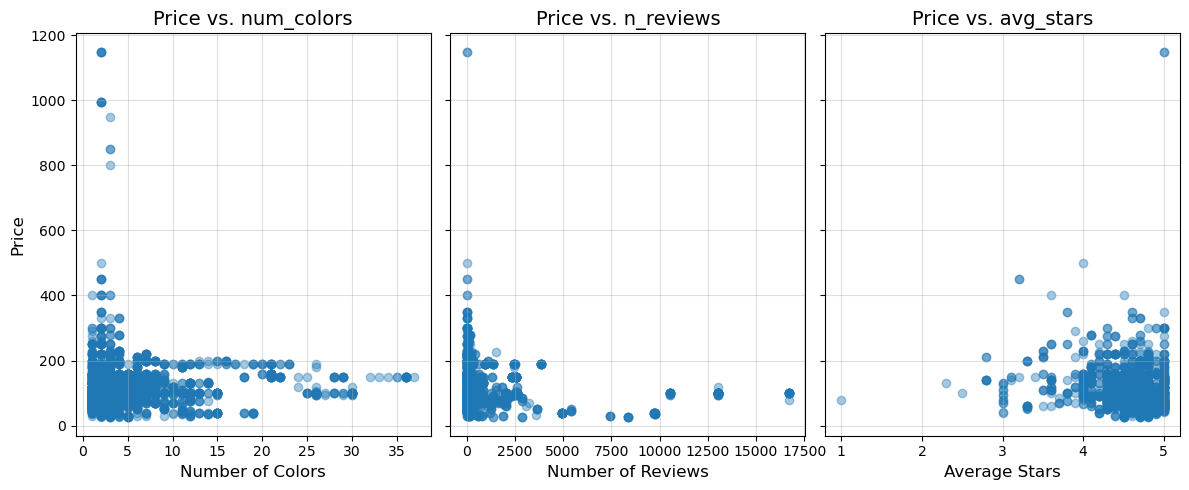

In [59]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 5))

fontsize = 14

cols = ["num_colors", "n_reviews", "avg_stars"] 
title_vs_text = ["num_colors", "n_reviews", "avg_stars"]
xlabels = ["Number of Colors", "Number of Reviews", "Average Stars"]

for i, (ax, col, title_vs, xlabel) in enumerate(
    zip(axes, cols, title_vs_text, xlabels)
):

    ax.scatter(adidas[col], adidas["price"], alpha=0.4)
    ax.set_title(
        f"Price vs. {title_vs}",
        fontsize=fontsize,
    )
    ax.set_xlabel(xlabel, fontsize=fontsize-2)
    ax.set_ylabel(
        "Price" if i==0 else None, 
        fontsize=fontsize-2
    )
    ax.grid(":", alpha=0.4)

plt.tight_layout()

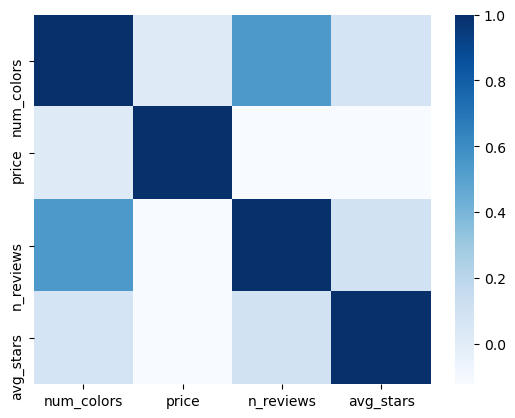

In [60]:
cor = adidas.drop('Unnamed: 0', axis=1).corr()

sns.heatmap(cor, cmap='Blues')
plt.show()

## Plot Categorical Variables

In [62]:
top_subtitles = adidas.subtitle.value_counts().head()
top_subtitles

Men's • Originals          290
Kids Unisex • Originals    222
Women's • Originals        167
Men's • Running            110
Women's • Running           97
Name: subtitle, dtype: int64

In [63]:
adidas_top_subtitles = adidas.loc[adidas.subtitle.isin(top_subtitles.index.tolist())]

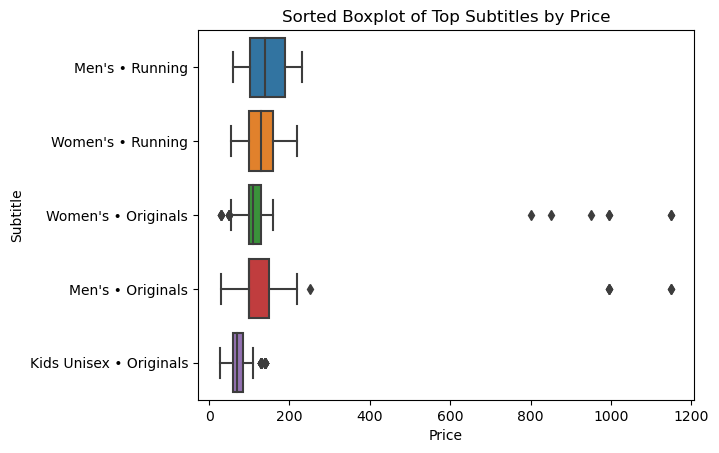

In [64]:
top_subtitles_sorted = adidas_top_subtitles.groupby('subtitle').price.median().sort_values(ascending=False)

# order box plot by median
sns.boxplot(data=adidas_top_subtitles, y='subtitle', x='price', order=top_subtitles_sorted.index)
plt.xlabel('Price')
plt.ylabel('Subtitle')
plt.title('Sorted Boxplot of Top Subtitles by Price')
plt.show()

## Numeric Stats

In [65]:
mean_price = adidas["price"].mean() 
mean_noc = adidas["num_colors"].mean()
std_price = adidas["price"].std() 
std_noc = adidas["num_colors"].std()
print(
    "\n"
    f"The mean price is {mean_price:.4f} \n"
    f"The mean number of colors is {mean_noc:.4f} \n"
    f"The Standard Deviation of price is {std_price:.4f}\n"
    f"The Standard Deviation of number of colors is {std_noc:.4f}"
)


The mean price is 119.7339 
The mean number of colors is 5.6943 
The Standard Deviation of price is 87.6957
The Standard Deviation of number of colors is 6.2613


In [66]:
price_min = adidas["price"].min()
price_max = adidas["price"].max() 
price_range = price_max - price_min 

print(
    f"The range of price for which shoes in our dataset "
    f"is {price_range:,.2f} dolloars. \n\n"
    f"The maximum number of price is {price_max:,.2f}, "
    f"and the minimum is {price_min:,.2f}."
)

The range of price for which shoes in our dataset is 1,125.00 dolloars. 

The maximum number of price is 1,150.00, and the minimum is 25.00.


/Users/mina/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


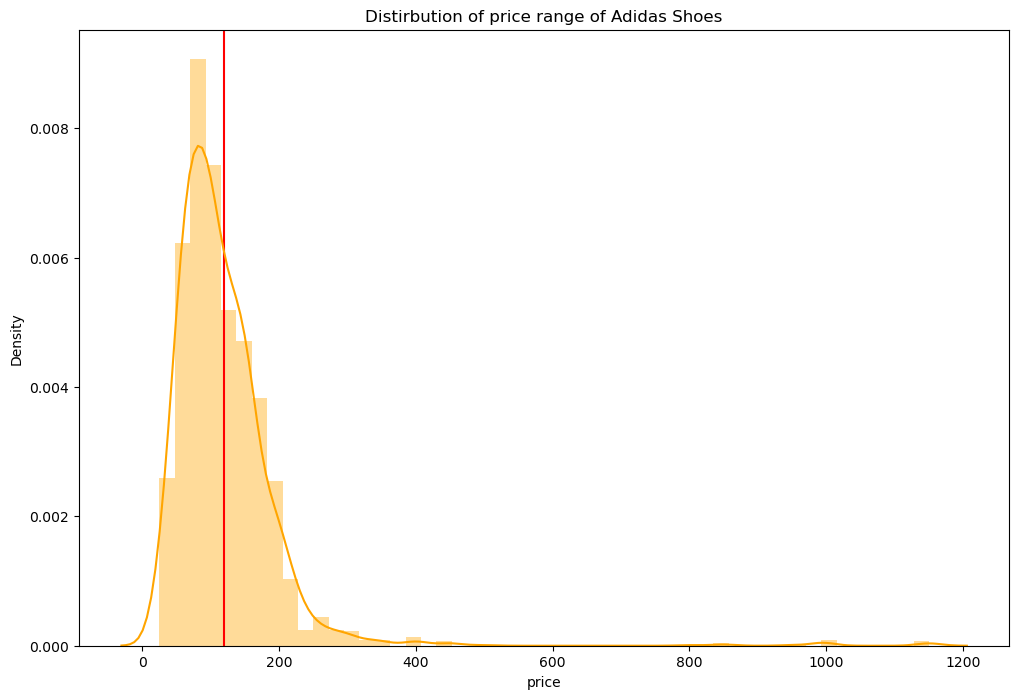

In [89]:
plt.figure(figsize=(12,8))
#ploting the mean
plt.axvline(mean_price, 0, 1, color = 'red')
sns.distplot(adidas['price'], color='orange')
plt.title("Distirbution of price range of Adidas Shoes")
plt.show()

## Missing Data

In [90]:
n_rows_with_missingness = np.int64(sum([True for idx,row in adidas.iterrows() if any(row.isnull())]))
n_cols_with_missingness = np.int64(sum(adidas.apply(lambda x: sum(x.isnull().values), axis = 0)>0))

columns = adidas.columns.values
col_num = []
for i in columns:
    col_num.append(adidas[i].isnull().sum())
col_missingness = pd.Series(col_num, index=adidas.columns)
col_missingness

Unnamed: 0         0
title              1
subtitle          30
num_colors        28
url                0
price              4
reduced_price    144
description       22
details          142
colors           445
n_reviews        210
avg_stars        210
product_code       0
dtype: int64

In [91]:
# Replaced Missing Values with Median For Now
median_price = adidas['price'].median()
adidas['price'].fillna(median_price, inplace=True)

In [19]:
# nike_train, y_train = nike_train.drop(columns=['price']), nike_train['price']
# nike_test, y_test = nike_test.drop(columns=['price']), nike_test['price']

In [20]:
# nike_train, y_train = nike_train.drop(columns=['reduced_price']), nike_train['reduced_price']
# nike_test, y_test = nike_test.drop(columns=['reduced_price']), nike_test['reduced_price']

In [21]:
# columns = nike_train.columns.values
# print(f'There are {len(columns)} in the Nike_train Data Frame:')
# for i in columns:
    # print(f'  The {i} column is missing {nike_train[i].isnull().sum()} values')

# MSE & R2 

In [93]:
mse_list = []
r2_list = []
# List of all predictor combinations to fit the curve
cols = [['num_colors'],['n_reviews'],['avg_stars'],['num_colors','n_reviews'],['avg_stars','n_reviews'],['num_colors','avg_stars'],['num_colors','n_reviews','avg_stars']]
adidas['num_colors'].fillna(adidas['num_colors'].median(), inplace=True)
adidas['n_reviews'].fillna(adidas['n_reviews'].median(), inplace=True)
adidas['avg_stars'].fillna(adidas['avg_stars'].median(), inplace=True)

In [95]:
from sklearn.metrics import mean_squared_error, r2_score

In [96]:
# Loop over all the predictor combinations 
for i in cols:
    # Replaced Missing Values with Median For Now
    
    print(i)
    # Set each of the predictors from the previous list as x
    x = adidas[i]
    # Set the "Sales" column as the reponse variable
    y = adidas['price']
   
    # Split the data into train-test sets with 80% training data and 20% testing data. 
    # Set random_state as 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8,random_state=0)

    # Initialize a Linear Regression model
    lreg = LinearRegression()

    # Fit the linear model on the train data
    lreg.fit(x_train,y_train)
    
    # Predict the response variable for the test set using the trained model
    y_pred= lreg.predict(x_test)
    
    # Compute the MSE for the test data
    MSE = mean_squared_error(y_pred,y_test)
    r2 = r2_score(y_test, y_pred)
    
    # Append the computed MSE to the list
    mse_list.append(MSE)
    r2_list.append(r2)

['num_colors']
['n_reviews']
['avg_stars']
['num_colors', 'n_reviews']
['avg_stars', 'n_reviews']
['num_colors', 'avg_stars']
['num_colors', 'n_reviews', 'avg_stars']


In [100]:
# Helper code to display the MSE for each predictor combination
t = PrettyTable(['Predictors', 'MSE'])
p = PrettyTable(['Predictors', 'R2 score'])

for i in range(len(mse_list)):
    t.add_row([cols[i],round(mse_list[i], 2)])
    p.add_row([cols[i],round(r2_list[i], 2)])
    

print(t)
print(p)

+------------------------------------------+---------+
|                Predictors                |   MSE   |
+------------------------------------------+---------+
|              ['num_colors']              | 8629.75 |
|              ['n_reviews']               | 8555.15 |
|              ['avg_stars']               | 8703.21 |
|       ['num_colors', 'n_reviews']        |  8481.9 |
|        ['avg_stars', 'n_reviews']        |  8621.9 |
|       ['num_colors', 'avg_stars']        | 8701.53 |
| ['num_colors', 'n_reviews', 'avg_stars'] | 8552.71 |
+------------------------------------------+---------+
+------------------------------------------+----------+
|                Predictors                | R2 score |
+------------------------------------------+----------+
|              ['num_colors']              |   -0.0   |
|              ['n_reviews']               |   0.01   |
|              ['avg_stars']               |  -0.01   |
|       ['num_colors', 'n_reviews']        |   0.02   |
|  

# Sentiment Analysis

In [101]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mina/nltk_data...


True

In [103]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

In [128]:
# copy new df to work on
df = adidas.loc[:, ['description', 'price']].copy()
df.dropna(inplace=True)

In [129]:
analyzer = SIA()
# using sentiment analysis and get negative, neutral, poisitve scores on columns "rating"
df['rating'] = df['description'].apply(analyzer.polarity_scores)
df

,description,price,rating
0,You'll want these adidas running shoes the nex...,65.0,"{'neg': 0.032, 'neu': 0.842, 'pos': 0.126, 'co..."
1,"One shoe to rule them all. School, work or kic...",130.0,"{'neg': 0.0, 'neu': 0.854, 'pos': 0.146, 'comp..."
2,"Comfort is key, whether you're racing to catch...",90.0,"{'neg': 0.035, 'neu': 0.854, 'pos': 0.111, 'co..."
3,Classics for a reason. These adidas slides are...,40.0,"{'neg': 0.0, 'neu': 0.777, 'pos': 0.223, 'comp..."
4,It doesn't really matter whether or not a run ...,85.0,"{'neg': 0.028, 'neu': 0.903, 'pos': 0.068, 'co..."
...,...,...,...
2385,We all fall in love with the beautiful game on...,70.0,"{'neg': 0.054, 'neu': 0.798, 'pos': 0.148, 'co..."
2386,Good players create time and space. Great ones...,130.0,"{'neg': 0.033, 'neu': 0.699, 'pos': 0.268, 'co..."
2387,Swerve ordinary to find your edge. Introduce a...,65.0,"{'neg': 0.0, 'neu': 0.963, 'pos': 0.037, 'comp..."
2388,The world's top runners enter the Berlin Marat...,180.0,"{'neg': 0.033, 'neu': 0.902, 'pos': 0.065, 'co..."


In [132]:
# change each keys/values of dictionary in colum, rating, to be the new columns of dataframe
df2 = pd.concat([df.drop(['rating'], axis=1), df['rating'].apply(pd.Series)], axis=1)
df2

,description,price,neg,neu,pos,compound
0,You'll want these adidas running shoes the nex...,65.0,0.032,0.842,0.126,0.7430
1,"One shoe to rule them all. School, work or kic...",130.0,0.000,0.854,0.146,0.8126
2,"Comfort is key, whether you're racing to catch...",90.0,0.035,0.854,0.111,0.6124
3,Classics for a reason. These adidas slides are...,40.0,0.000,0.777,0.223,0.9413
4,It doesn't really matter whether or not a run ...,85.0,0.028,0.903,0.068,0.4232
...,...,...,...,...,...,...
2385,We all fall in love with the beautiful game on...,70.0,0.054,0.798,0.148,0.9287
2386,Good players create time and space. Great ones...,130.0,0.033,0.699,0.268,0.9810
2387,Swerve ordinary to find your edge. Introduce a...,65.0,0.000,0.963,0.037,0.2960
2388,The world's top runners enter the Berlin Marat...,180.0,0.033,0.902,0.065,0.2732


In [133]:
df2['score'] = np.where(df2['compound'] < 0, 'negative', 'positive')
df2

,description,price,neg,neu,pos,compound,score
0,You'll want these adidas running shoes the nex...,65.0,0.032,0.842,0.126,0.7430,positive
1,"One shoe to rule them all. School, work or kic...",130.0,0.000,0.854,0.146,0.8126,positive
2,"Comfort is key, whether you're racing to catch...",90.0,0.035,0.854,0.111,0.6124,positive
3,Classics for a reason. These adidas slides are...,40.0,0.000,0.777,0.223,0.9413,positive
4,It doesn't really matter whether or not a run ...,85.0,0.028,0.903,0.068,0.4232,positive
...,...,...,...,...,...,...,...
2385,We all fall in love with the beautiful game on...,70.0,0.054,0.798,0.148,0.9287,positive
2386,Good players create time and space. Great ones...,130.0,0.033,0.699,0.268,0.9810,positive
2387,Swerve ordinary to find your edge. Introduce a...,65.0,0.000,0.963,0.037,0.2960,positive
2388,The world's top runners enter the Berlin Marat...,180.0,0.033,0.902,0.065,0.2732,positive


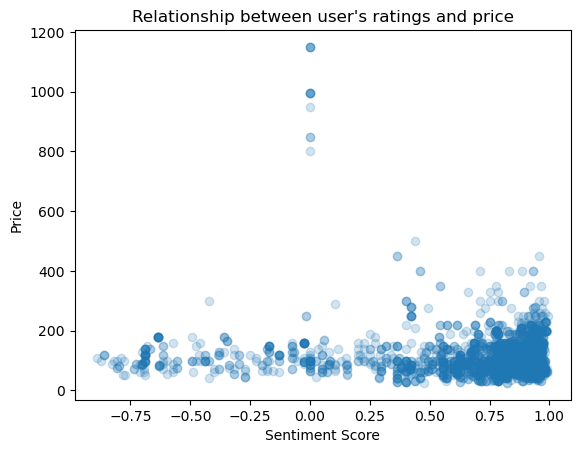

In [143]:
plt.scatter(df2['compound'], df2["price"], alpha=0.2)
plt.xlabel("Sentiment Score")
plt.ylabel("Price")
plt.title("Relationship between user's ratings and price")
plt.show()

In [160]:
X = df2[['compound']]
y = df2['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=109)

In [161]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1776, 1), (592, 1), (1776,), (592,))

In [164]:
lreg = LinearRegression().fit(X_train, y_train)

y_pred = lreg.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print("MSE is {:.4f}; R score is {:.4f}".format(MSE,r2))

MSE is 7201.5611; R score is 0.0001


# Just for the nagative score description

In [139]:
positive_des = (df2['score']=='positive').sum()
negative_des = (df2['score']=='negative').sum()
print(f"There are {positive_des} positive descritions and {negative_des} negative descriptions.")

There are 2153 positive descritions and 215 negative descriptions.


In [140]:
neg = df2[df2['score']=='negative']
neg

,description,price,neg,neu,pos,compound,score
9,These adidas sneakers are tasteful and minimal...,60.0,0.110,0.829,0.061,-0.4902,negative
21,Timeless appeal. Effortless style. Everyday ve...,95.0,0.048,0.905,0.047,-0.0258,negative
31,"When worlds collide, magic happens. These adid...",70.0,0.036,0.964,0.000,-0.0772,negative
37,Millions of people have laced into adidas Stan...,100.0,0.103,0.851,0.047,-0.8176,negative
47,"Remember the epic shots, close games and fierc...",110.0,0.036,0.934,0.031,-0.0772,negative
...,...,...,...,...,...,...,...
2294,"Statement makers and risk takers, these adidas...",100.0,0.148,0.734,0.118,-0.0562,negative
2301,"When you step onto the pitch, don't just play ...",50.0,0.115,0.860,0.025,-0.7805,negative
2317,Throw it back to '70s Southern California skat...,65.0,0.065,0.905,0.031,-0.2023,negative
2325,Strike when your opponent least expects it. Dr...,150.0,0.118,0.789,0.092,-0.1697,negative


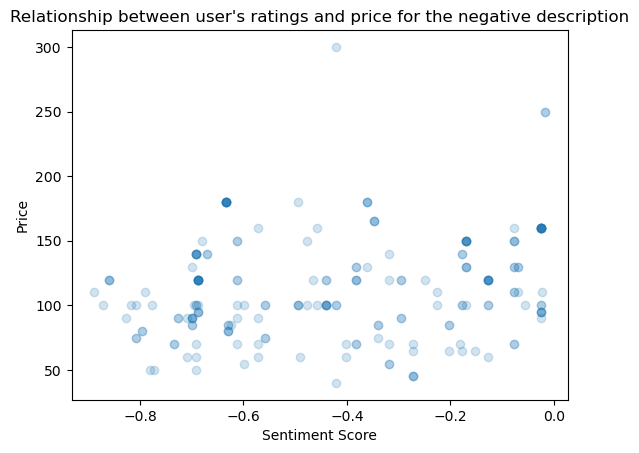

In [142]:
plt.scatter(neg['compound'], neg["price"], alpha=0.2)
plt.xlabel("Sentiment Score")
plt.ylabel("Price")
plt.title("Relationship between user's ratings and price for the negative description")
plt.show()

In [165]:
X_n = neg[['compound']]
y_n = neg['price']
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, train_size=0.75, shuffle=True, random_state=109)

In [166]:
X_train_n.shape, X_test_n.shape, y_train_n.shape, y_test_n.shape

((161, 1), (54, 1), (161,), (54,))

In [170]:
# Fitting Linear Regression 
lreg = LinearRegression()
linreg = lreg.fit(X_train_n,y_train_n)
# Compute the MSE of the model
y_hat_train_n = lreg.predict(X_train_n)
lin_train_mse_n = mean_squared_error(y_train_n, y_hat_train_n)

y_hat_test_n = lreg.predict(X_test_n)
lin_test_mse_n = mean_squared_error(y_test_n, y_hat_test_n)

# Compute the R-squared of the model
r2_n = r2_score(y_test_n, y_hat_test_n)

In [171]:
print("Train MSE is {:.4f} and Test MSE is {:.4f}".format(lin_train_mse_n,lin_test_mse_n,))
print(f"Test R-squared is {r2_n:.4f}")

Train MSE is 1508.9320 and Test MSE is 1451.7917
Test R-squared is 0.0277


# NLP Section

In [173]:
df_desc = adidas.loc[:, ['description', 'price']].copy()  # subset
df_desc.dropna(inplace=True)  # drop na
df_desc.head()

,description,price
0,You'll want these adidas running shoes the nex...,65.0
1,"One shoe to rule them all. School, work or kic...",130.0
2,"Comfort is key, whether you're racing to catch...",90.0
3,Classics for a reason. These adidas slides are...,40.0
4,It doesn't really matter whether or not a run ...,85.0


In [174]:
# Following Tom's Nike NLP section codes
df_desc['description'] = df_desc['description'].str.lower()
df_desc['description'] = df_desc['description'].str.replace(r'([^\w\s]|_)+', '', regex=True)
df_desc['description'] = df_desc['description'].str.split()
stopwords = pd.read_csv('data/stopwords_nopunc.csv').stopwords.values
df_desc['description'] = df_desc['description'].apply(lambda x: [str(w) for w in x if w not in stopwords])
vocab_counts = df_desc['description'].explode().value_counts()
min_count = 5
vocab = [k for k,v in vocab_counts.items() if v >= 5]
print(f"We have {len(vocab):,} unique word in our reduced, corpus vocabulary.")

We have 2,412 unique word in our reduced, corpus vocabulary.


In [127]:
df_desc['description'] = df_desc['description'].apply(lambda x: [w for w in x if w in vocab])
counts = df_desc['description'].apply(Counter).to_list()
bow_df = pd.DataFrame(counts).fillna(0).astype(int)
bow_df

,want,adidas,running,shoes,next,time,step,route,classic,lines,...,lightningquick,sprintskin,relieving,orketro,empty,hellcat,extension,innings,cleated,agile
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2364,0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2365,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2366,0,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
df_desc.reset_index(drop=True, inplace=True)
df_processed = pd.concat([bow_df, df_desc['price']], axis=1)
df_processed['price'] = pd.cut(df_processed['price'], bins=5)
df_processed['price'] = df_processed['price'].astype('string')

# Naive Bayes

In [176]:
X_train, X_test, y_train, y_test = train_test_split(df_processed.drop('price', axis=1),
                                                    df_processed['price'], test_size=0.2, random_state=109)

In [179]:
mnb = MultinomialNB().fit(X_train, y_train)
mnb.score(X_test, y_test)

0.9556962025316456

# Linear Support Vector Machine

In [180]:
from sklearn.linear_model import SGDClassifier

In [181]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)

In [182]:
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
accuracy

0.9873417721518988

# Logistic Regression

In [183]:
from sklearn.linear_model import LogisticRegression

In [185]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy_log = accuracy_score(y_pred, y_test)
accuracy_log

/Users/mina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9873417721518988